## Developed notebook for applying cross-correlation technique at low latitudes. Here we will study the Carajas area, located at Para, North, Brazil.

In [1]:
# Import packages
import sys
import scipy
import numpy
import pandas
from scipy.stats import norm
from matplotlib import pyplot
from scipy.interpolate import griddata
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.basemap import Basemap

In [3]:
a = sys.path.append('/home/delimar/Documents/sources/')

## Part 1 - Reading the file and analyzing it

In [2]:
# There are six channels and a tab delimitation. Besides we have to skip one single row.
X, Y, Long, Lat, Tf, F = numpy.loadtxt('realdata/carajas_mag.XYZ', 
                                       skiprows=1, usecols=(0,1,2,3,4,5), unpack = True)

In [4]:
# Define the area
geografic_area = (Long.min(), Long.max(), Lat.min(), Lat.max())
projected_area = (X.min(), X.max(), Y.min(), Y.max())

In [5]:
print 'Study area (degrees):', numpy.round(geografic_area, decimals = 3)
print 
print 'Study area (meters):', numpy.round(projected_area, decimals = 2)

Study area (degrees): [-51.815 -49.475  -4.03   -2.921]

Study area (meters): [  409432.   669346.  9554600.  9677098.]


In [6]:
# Define the minimum and maximum values
longmin = numpy.round(Long.min(), decimals = 2)
longmax = numpy.round(Long.max(), decimals = 2)
latmin = numpy.round(Lat.min(), decimals = 2)
latmax = numpy.round(Lat.max(), decimals = 2)

In [7]:
# Analysing the total field anomaly data
print 'Total field anomaly data:'
print 'Min:', Tf.min()
print 'Max:', Tf.max()

Total field anomaly data:
Min: -4230.0
Max: 878.0


In [8]:
# Analysing the total field intensity data
print 'Total field anomaly data:'
print 'Min:', F.min()
print 'Max:', F.max()

Total field anomaly data:
Min: 23037.0
Max: 28142.0


## Part 2 - Scattering all points

pyplot.close('all')
figure1 = pyplot.figure(figsize=(8,8))

p1 = pyplot.scatter(Long, Lat, s = 1., c = Tf, marker = '.', cmap = pyplot.cm.jet)
cbar1 = pyplot.colorbar(p1, aspect = 30, fraction = 0.03, orientation = 'vertical')
cbar1.set_label('Total field anomaly (nT)',fontsize = 15, rotation = -90, labelpad = 20)
cbar1.set_ticks(numpy.linspace(Tf.min(), Tf.max(), 8))
cbar1.set_clim(Tf.min(), Tf.max())

pyplot.title('Flight lines of aeromagnetic survey',fontsize = 16, pad = 10)
pyplot.xlabel('Longitude ($^o$)', fontsize = 15)
pyplot.ylabel('Latitude ($^o$)', fontsize = 15)
pyplot.xlim(longmin, longmax)
pyplot.ylim(latmin, latmax)
pyplot.xticks(numpy.linspace(longmin, longmax, 5), fontsize = 12)
pyplot.yticks(numpy.linspace(latmin, latmax, 5), fontsize = 12)

pyplot.savefig('figure01-flight-lines.png', dpi = 300, transparence = True, bbox_inches = 'tight')
pyplot.savefig('figure01-flight-lines.pdf', dpi = 300, transparence = True, bbox_inches = 'tight')
pyplot.show()

pyplot.close('all')
figure2 = pyplot.figure(figsize=(8,8))

p2 = pyplot.scatter(Long, Lat, s = 1., c = F, marker = '.', cmap = pyplot.cm.rainbow)
cbar2 = pyplot.colorbar(p2, aspect = 30, fraction = 0.03, orientation = 'vertical')
cbar2.set_label('Magnetic field intensity (nT)', fontsize = 15, rotation = -90, labelpad = 20)
cbar2.set_ticks(numpy.linspace(F.min(), F.max(), 8))
cbar2.set_clim(F.min(), F.max())

pyplot.title('Flight lines of aeromagnetic survey',fontsize = 16, pad = 10)
pyplot.xlabel('Longitude ($^o$)', fontsize = 15)
pyplot.ylabel('Latitude ($^o$)', fontsize = 15)
pyplot.xlim(longmin, longmax)
pyplot.ylim(latmin, latmax)
pyplot.xticks(numpy.linspace(longmin, longmax, 5), fontsize = 12)
pyplot.yticks(numpy.linspace(latmin, latmax, 5), fontsize = 12)

pyplot.savefig('figure02-flight-lines.png', dpi = 300, transparence = True, bbox_inches = 'tight')
pyplot.savefig('figure02-flight-lines.pdf', dpi = 300, transparence = True, bbox_inches = 'tight')
pyplot.show()

## Part 2 - Interpolate the data and drawing the basemap

In [9]:
# Define number of points and shape
num = 250
longitude = numpy.linspace(longmin, longmax, num)
latitude = numpy.linspace(latmin, latmax, num)

In [10]:
# Creates the grid
gridlong, gridlat = numpy.meshgrid(longitude, latitude)

In [11]:
# Create the tuples
flightcoordinates = (Long, Lat)
gridcoordinates = (gridlong, gridlat)

In [12]:
# Interpolate the total field anomaly data and also the magnetic field intensity
Tfi = griddata(flightcoordinates, Tf, gridcoordinates, method = 'cubic')
Fi = griddata(flightcoordinates, F, gridcoordinates, method = 'cubic')

In [13]:
# Setting values for colorbar:
vtfmin = Tf.min()
vtfmax = Tf.max()
vfmin = F.min()
vfmax = F.max()

In [14]:
# Setting the central values
long0 = 0.5*(longmin + longmax)
lat0 = 0.5*(latmin + latmax)

## Part 3 - Interpolation to apply cross-correlation

In [15]:
# Import usefull libraries
from utm import from_latlon
from codes import grids, statistical, filtering, derivative, equivalentlayer

Here we will work with projected coordinates 

In [16]:
# Find the utm zone of all data:
pp = []
for k in range(Long.size):
    l = from_latlon(Lat[k], Long[k])
    pp.append(l[2])

In [17]:
# Show the zone number
numpy.min(pp), numpy.max(pp)

(22, 22)

In [18]:
# Select our study area
#cornerxmin = (Long.any() <= -50.75 and Long.any() >= -51.)
#cornerxmax = Long >= -51.
#cornerymin = Lat <= -3.
#cornerymax = Lat >= -3.25

In [19]:
# Define the grid informations
shape = (40, 40)
h = -50.

In [20]:
# Create the grid
long0, lati0, zo = grids.regular_grid((-51., -50.7, -3.3, -3.), shape, h)

In [21]:
# Create the empty list
xo = []
yo = []

In [22]:
# Convert to UTM
for k in range(long0.size):
    xy = from_latlon(lati0[k], long0[k], force_zone_number = 22)
    xo.append(xy[0])
    yo.append(xy[1])

In [23]:
# Convert as array
xo = numpy.array(xo)
yo = numpy.array(yo)

In [24]:
# New total field anomaly data
tf = griddata((X, Y), Tf, (xo, yo), method = 'cubic', fill_value = 0.)

In [25]:
# New central points
newlong0 = 0.5*(long0.min() + long0.max())
newlati0 = 0.5*(lati0.min() + lati0.max())

In [26]:
# Define the new basemap
# Creating the bsaemap location
map3 = Basemap(llcrnrlon = long0.min(), llcrnrlat = lati0.min(),
               urcrnrlon = long0.max(), urcrnrlat = lati0.max(), 
               resolution = 'i', projection = 'tmerc', 
               lon_0 = newlong0, lat_0 = newlati0, epsg = 3395)

In [27]:
# Define meridians and parallels
meridians2 = numpy.linspace(0., 360., 721)
parallels2 = numpy.linspace(-90., 90., 361)

For the equivalent layer - vectors: $\left[\bar{xo}, \bar{yo}, \bar{zo}, \bar{tf} \right]$

For the reduction filter - matrixs: $\left[\mathbf{X_o}, \mathbf{Y_o},  \mathbf{Z_o}, \mathbf{TF_o} \right]$

In [28]:
# Reshape the data
Xo = xo.reshape(shape)
Yo = yo.reshape(shape)
Zo = zo.reshape(shape)
TF = tf.reshape(shape)

In [29]:
UP = filtering.continuation(Yo, Xo, TF, 2000.)

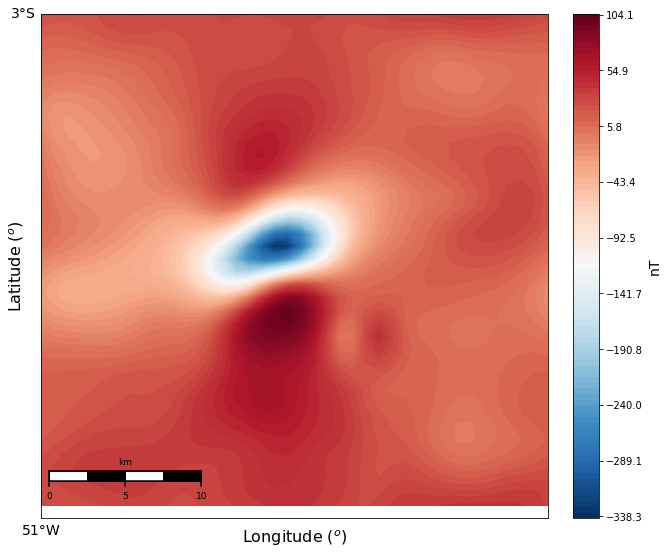

In [49]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10, 10))

map3.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawmapscale(-50.95, -3.275, newlong0.max(), newlati0.max(), 10, barstyle = 'fancy')
cs2 = map3.contourf(long0.reshape(shape), lati0.reshape(shape), UP, 100, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map3.colorbar(cs2, location = 'right', size = '5%', pad = '5%')
cbar.set_label('nT', fontsize = 14, rotation = 90, labelpad = 5)
cbar.set_ticks(numpy.linspace(UP.min(), UP.max(), 10))
cbar.set_clim(UP.min(), UP.max())

#pyplot.suptitle('Observed magnetic total field anomaly (nT)', fontsize = 18, y = 0.82)
pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 10)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 15)

pyplot.show()

In [42]:
# Loading the magnetic inclination and declination from IGRF
inclination = numpy.loadtxt('realdata/inc_carajas.csv', delimiter = ',', usecols=(4))
declination = numpy.loadtxt('realdata/dec_carajas.csv', delimiter = ',', usecols=(4))
magfield = numpy.loadtxt('realdata/field_carajas.csv', delimiter = ',', usecols=(4))

In [43]:
# Set the inclination and declination values
incf = inclination.mean()
decf = declination.mean()
field = magfield.mean()

In [44]:
print 'Inclination:', incf
print 'Declination:', decf
print 'Magnetic field:', field

Inclination: 7.14828539394
Declination: -17.3913058656
Magnetic field: 27279.4775


In [45]:
# Create the equivalent layer
#areal = (xo.min() + 7000., 
#         xo.max() - 4000., 
#         yo.min() + 4000., 
#         yo.max() - 9000.)
areal = (yo.min(), yo.max(), xo.min(), xo.max())
shapel = (15, 15)
level = 6000.
EQL = equivalentlayer.layer(areal, shapel, level)

In [46]:
# Define the data
#datalayer = [yo, xo, zo, tf]
datalayer = [yo, xo, zo, UP.reshape(UP.size)]

In [47]:
qpo, pred = equivalentlayer.fit_layer(datalayer, shape, EQL, shapel, 0.001, incf, decf)

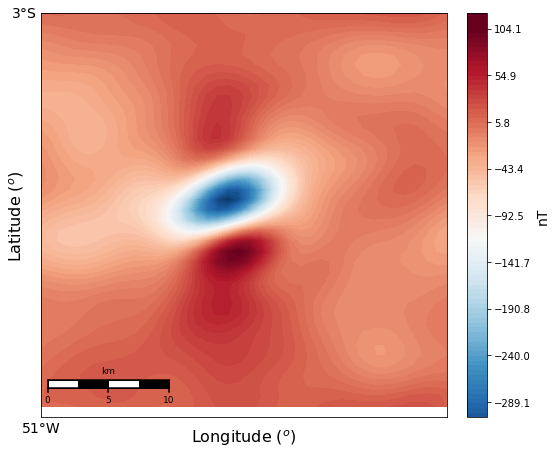

In [79]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(8, 8))

map3.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawmapscale(-50.95, -3.275, newlong0.max(), newlati0.max(), 10, barstyle = 'fancy')
cs2 = map3.contourf(long0.reshape(shape), lati0.reshape(shape), pred.reshape(shape), 100, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map3.colorbar(cs2, location = 'right', size = '5%', pad = '5%')
cbar.set_label('nT', fontsize = 14, rotation = 90, labelpad = 5)
cbar.set_ticks(numpy.linspace(UP.min(), UP.max(), 10))
cbar.set_clim(UP.min(), UP.max())

#pyplot.suptitle('Observed magnetic total field anomaly (nT)', fontsize = 18, y = 0.82)
pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 10)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 15)

pyplot.show()

In [51]:
residuo = tf - pred
res_mu = numpy.mean(residuo)
res_sigma = numpy.std(residuo)

/home/delimar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


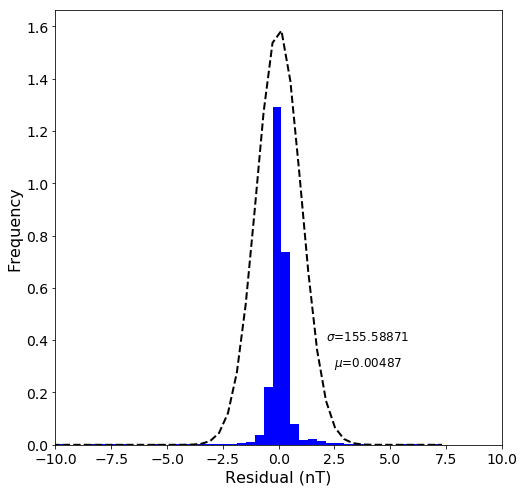

In [52]:
pyplot.figure(figsize=(8,8))
s = (residuo - res_mu) / res_sigma
s = numpy.ravel(s)
nbins = int(numpy.max(s) - numpy.min(s))
n, bins, patches = pyplot.hist(s, 50, normed = True, facecolor = 'blue', alpha = 1.)
y_hist = norm.pdf(bins, numpy.mean(s), numpy.std(s))
pyplot.plot(bins, 4*y_hist, 'k--', linewidth = 2)
pyplot.text(4,0.3, '$\mu$=%0.5f' % (res_mu), horizontalalignment = 'center', fontsize = 12)
pyplot.text(4,0.4, '$\sigma$=%0.5f' % (res_sigma), horizontalalignment = 'center', fontsize = 12)
pyplot.xlabel('Residual (nT)' , fontsize = 16)
pyplot.ylabel('Frequency', fontsize = 16)
pyplot.xlim(-10,10)
pyplot.xticks(fontsize = 14)
pyplot.yticks(fontsize = 14)
#pyplot.savefig('cap04a-histograma.png', dpi = 300, bbox_inches = 'tight', transparent = True)
#pyplot.savefig('cap04a-histograma.pdf', dpi = 300, bbox_inches = 'tight', transparent = True)
pyplot.show()

In [53]:
# Create the inclination and declination grids
#inc, dec = regular_grid((-90., 90., -90., 90.), (37, 31))
I = numpy.linspace(-90., 90., 37)
D = numpy.linspace(-90., 90., 19)
dec, inc = numpy.meshgrid(D, I)

In [54]:
# Create the zero-array to allocate the results
res =  numpy.zeros_like(dec)

In [55]:
# Import the time computation:
from time import time

In [59]:
# Compute the cros-correlation
# Initial time
time1 = time()
for cols, d in enumerate(D):
    for rows, i in enumerate(I):
        if i >= -15. or i <= 15.:
            rtpdata = equivalentlayer.rtp_layer(datalayer, shape, EQL, shapel, 0.001, incf, decf, i, d)
            res[rows, cols] = statistical.cccoef(derivative.totalgrad(Yo, Xo, rtpdata.reshape(shape)), 
                                                 derivative.zderiv(Yo, Xo, rtpdata.reshape(shape)))
        else:
            rtpdata = filtering.reduction(Yo, Xo, UP, incf, decf, i, d)
            res[rows, cols] = statistical.cccoef(totalgrad(Yo, Xo, rtpdata), 
                                                 derivative.zderiv(Yo, Xo, rtpdata))
# Final time
time2 = time()

In [60]:
# Show computation time
print 'Computation time (sec): %.3f' % (time2 - time1)

Computation time (sec): 555.926


In [61]:
# Analysing the positive coefficients
print 'Full cross correlation:'
print 'Minimun:', res.min()
print 'Maximun:', res.max()

Full cross correlation:
Minimun: -0.0988554451501
Maximun: 0.556719529882


In [62]:
# Search for the maximum and minimum pair of inclination and declination
imax, jmax = numpy.where(res == res.max())
imin, jmin = numpy.where(res == res.min())
incmax = float(inc[imax, jmax])
decmax = float(dec[imax, jmax])
incmin = float(inc[imin, jmin])
decmin = float(dec[imin, jmin])
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax
print 'Declination:', decmax

(I,D) for maximum coefficient
Inclination: -5.0
Declination: 10.0


/home/delimar/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


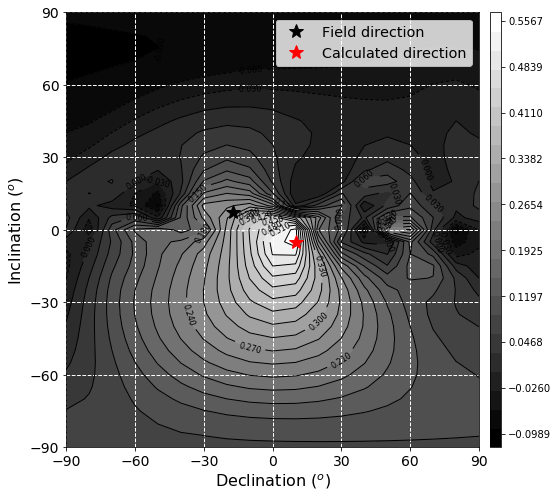

In [63]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 8))
# Line contour
c1 = pyplot.contour(dec, inc, res, 25, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 8)
# Map contour and colorbar
c2 = pyplot.contourf(dec, inc, res, 25, vmin = res.min(), vmax = res.max(), cmap = pyplot.cm.gray)
cbar2 = pyplot.colorbar(c2, aspect = 40, fraction = 0.05, orientation = 'vertical', pad = 0.025)
cbar2.set_ticks(numpy.linspace(res.min(), res.max(), 10))
cbar2.set_clim(res.min(), res.max())
# Plot configuration
pyplot.plot(decf, incf, 'k*', label = 'Field direction', markersize = 14)
pyplot.plot(decmax, incmax, 'r*', label = 'Calculated direction', markersize = 14)
#pyplot.title('Distribution of cross-correlation coefficients', fontsize = 18)
pyplot.xlabel('Declination $(^o)$', fontsize = 16)
pyplot.ylabel('Inclination $(^o)$', fontsize = 16)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 7), fontsize = 14)
pyplot.legend(loc = 'best', fontsize = 'x-large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 1.)

pyplot.show()

In [65]:
# Create the new grids to interpolate
area2interp = (I.min(), I.max(), D.min(), D.max())
shape2interp = (181, 181)
INC, DEC = grids.regular_grid(area2interp, shape2interp)

In [66]:
R = res.reshape(res.size)

In [67]:
# Interpolate the result
RES = griddata((inc.reshape(inc.size), dec.reshape(dec.size)), R, (INC, DEC), method = 'cubic', rescale=True)

In [68]:
# Reshape the interpolated result
DEC = DEC.reshape(shape2interp)
INC = INC.reshape(shape2interp)
RES = RES.reshape(shape2interp)

In [69]:
# Search for the interpolated result
p1, p2 = numpy.where(RES == RES.max())
pimax = float(INC[p1, p2])
pdmax = float(DEC[p1, p2])
print '(I,D) for maximum coefficient'
print 'Inclination:', pimax
print 'Declination:', pdmax

(I,D) for maximum coefficient
Inclination: -2.0
Declination: 7.0


In [70]:
print RES.max()

0.588712184789


In [71]:
# Defines the colorbar
ccmin = RES.min()
ccmax = RES.max()

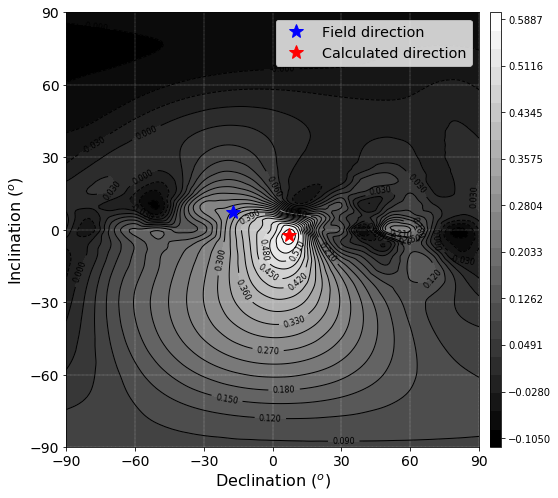

In [73]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 8))
# Line contour
c1 = pyplot.contour(DEC, INC, RES, 25, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 8)
# Map contour and colorbar
c2 = pyplot.contourf(DEC.reshape(shape2interp), INC.reshape(shape2interp), RES.reshape(shape2interp), 
                     25, vmin = ccmin, vmax = ccmax, cmap = pyplot.cm.gray)
cbar2 = pyplot.colorbar(c2, aspect = 40, fraction = 0.05, orientation = 'vertical', pad = 0.025)
cbar2.set_ticks(numpy.linspace(ccmin, ccmax, 10))
cbar2.set_clim(ccmin, ccmax)
# Plot configuration
pyplot.plot(decf, incf, 'b*', label = 'Field direction', markersize = 14)
pyplot.plot(pdmax, pimax, 'r*', label = 'Calculated direction', markersize = 14)
pyplot.xlabel('Declination $(^o)$', fontsize = 16)
pyplot.ylabel('Inclination $(^o)$', fontsize = 16)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 7), fontsize = 14)
pyplot.legend(loc = 'best', fontsize = 'x-large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 0.25)

pyplot.show()

In [75]:
# Calculates the RTP data
Rtp = equivalentlayer.rtp_layer(datalayer, shape, EQL, shapel, 0.001, incf, decf, pimax, pdmax)

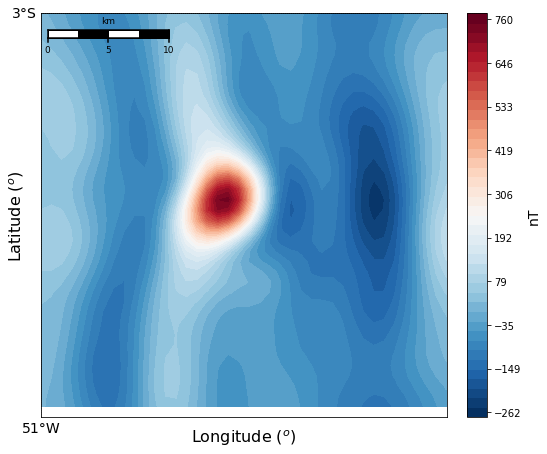

In [78]:
pyplot.figure(figsize=(8,8))
map3.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14)
map3.drawmapscale(-50.95, -3.015, newlong0.max(), newlati0.max(), 10, barstyle = 'fancy')
cs3 = map3.contourf(long0.reshape(shape), lati0.reshape(shape), Rtp.reshape(shape), 50, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map3.colorbar(cs3, location = 'right', size = '5%', pad = '5%')
cbar.set_label('nT', fontsize = 14, rotation = 90, labelpad = 5)
cbar.set_ticks(numpy.linspace(Rtp.min(), Rtp.max(), 10))
cbar.set_clim(Rtp.min(), Rtp.max())
pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 10)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 15)
pyplot.show()